# Recurrent Neural Network for Financial Time Series

## David Long

### CFRM 521, University of Washington, Spring 2022 (Lu)

This project is based on Long Short-Term Memory Neural Network for Financial Time Series by Carmina Fjellström. (https://arxiv.org/abs/2201.08218)

The investigation uses the Long-Short Term Memory variant of the Recurrent Neural Network to make the one-step ahead forecast of time series of financial returns.  Many LSTM models are trained in parallel, each with a different weight initialization, and a hard-voting classifier is used to resolve them.  The target variable is whether the one-step ahead return will be greater than the day’s median return.  The author uses data from Stockholm’s OMX30 and makes rolling predictions 30 days at a time.  For evaluation, a trading strategy based on the predictions is compared to holding the entire market and a random portfolio.

For this investigation, the Nasdaq 100 is used, as determined on 05/16/22 by (https://www.slickcharts.com/nasdaq100)    Adjusted closing prices are downloaded from Yahoo Finance using Python’s yfinance package.  An attempt was made to replace the hard-voting classifier with a logistic regression blender.  The author argued for an ensemble method to boost accuracy, but after conferring with the professor, I've decided against using an ensemble entirely.  Common practice is to let the activation function determine the weight initialization, so rather than train multiple models for each stock, many of which will have low accuracy due to bad weight initialization, it seems like the computational time would be better spent tuning the hyperparameters of a single model for each stock.  The activation functions in the LSTM cells are sigmoid and tanh, so the only weight initialization that will be used are Glorot Normal and Glorot Uniform.

The trading strategy will differ as well.  Fjellström uses a daily portfolio, owning all the stocks that are predicted to be above the median on each day of the prediction window.  This is not a trading strategy that most investors can engage in.  Instead, this investigation will seek to identify models with high cross-validation prediction accuracies.  For such models, the number of days predicted  above the median becomes relevant.  The recommended strategy will be to identify a stock with high prediction accuracy and a high number of days predicted above the median.  Buy the stock at the start of the prediction window and sell it at the end.  The returns given in the results summary are calculated from those two prices.  With this trading strategy in place, the model seeks to inform the investor, who must make discretionary decisions, rather than to dictate a course of action.  For a given prediction window, the best course of action may be to own one stock, several stocks, or no stocks at all.

***Before jumping into the script, specify values for reload_import_list, train_models and stocks_to_process, as described in the comments below.  They are currently set to import a saved data file of prices and to train models for all stocks in stocks_to_process.***

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import reciprocal
import sys
import random
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print('Python Version:', sys.version)
print('YFinance Version:', yf.__version__)
print('Pandas Version:', pd.__version__)
print('Numpy Version:', np.__version__)
print('Tensorflow Version:', tf.__version__)
print('Keras Version:', keras.__version__, '\n')

Python Version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
YFinance Version: 0.1.70
Pandas Version: 1.4.2
Numpy Version: 1.19.5
Tensorflow Version: 2.3.0
Keras Version: 2.4.0 



In [2]:
t0 = time.time()

# stock list set on 05/16/22 from https://www.slickcharts.com/nasdaq100
import_list = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOG', 'GOOGL', 'FB', 'NVDA'
              , 'AVGO', 'PEP', 'COST', 'CSCO', 'ADBE', 'CMCSA', 'INTC'
              , 'TMUS', 'TXN', 'AMD', 'QCOM', 'AMGN', 'HON', 'INTU', 'AMAT'
              , 'MDLZ', 'PYPL', 'ADP', 'SBUX', 'BKNG', 'NFLX', 'ADI', 'CHTR'
              , 'MU', 'ISRG', 'GILD', 'CSX', 'REGN', 'LRCX', 'VRTX', 'FISV'
              , 'ATVI', 'MRNA', 'MAR', 'KHC', 'KDP', 'KLAC', 'AEP', 'MRVL'
              , 'PANW', 'NXPI', 'MNST', 'EXC', 'ASML', 'FTNT', 'ABNB', 'ADSK'
              , 'PAYX', 'ORLY', 'SNPS', 'XEL', 'MELI', 'CDNS', 'CTAS', 'CTSH'
              , 'LULU', 'WBA', 'MCHP', 'ILMN', 'AZN', 'DLTR', 'WDAY', 'EA'
              , 'CRWD', 'ROST', 'DXCM', 'ODFL', 'JD', 'IDXX', 'FAST', 'LCID'
              , 'BIIB', 'PCAR', 'DDOG', 'VRSK', 'BIDU', 'EBAY', 'TEAM'
              , 'CPRT', 'SGEN', 'SIRI', 'ZM', 'ANSS', 'MTCH', 'ALGN', 'ZS'
              , 'NTES', 'VRSN', 'CEG', 'SWKS', 'PDD', 'SPLK', 'DOCU', 'OKTA']
print('import_list:', import_list, '\n')

# if True, the prices will be downloaded and saved locally
reload_import_list = False
if reload_import_list:
    prices = yf.download(import_list, start="2015-01-01", end="2022-03-31")['Adj Close']
    prices.to_pickle('prices_data.csv')
    print('prices fields downloaded:', set(prices.columns.get_level_values(0)))
else:
    prices = pd.read_pickle('prices_data.csv')
    
# if True, new models will be trained for each stock in stocks_to_process
train_models = True

import_list: ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOG', 'GOOGL', 'FB', 'NVDA', 'AVGO', 'PEP', 'COST', 'CSCO', 'ADBE', 'CMCSA', 'INTC', 'TMUS', 'TXN', 'AMD', 'QCOM', 'AMGN', 'HON', 'INTU', 'AMAT', 'MDLZ', 'PYPL', 'ADP', 'SBUX', 'BKNG', 'NFLX', 'ADI', 'CHTR', 'MU', 'ISRG', 'GILD', 'CSX', 'REGN', 'LRCX', 'VRTX', 'FISV', 'ATVI', 'MRNA', 'MAR', 'KHC', 'KDP', 'KLAC', 'AEP', 'MRVL', 'PANW', 'NXPI', 'MNST', 'EXC', 'ASML', 'FTNT', 'ABNB', 'ADSK', 'PAYX', 'ORLY', 'SNPS', 'XEL', 'MELI', 'CDNS', 'CTAS', 'CTSH', 'LULU', 'WBA', 'MCHP', 'ILMN', 'AZN', 'DLTR', 'WDAY', 'EA', 'CRWD', 'ROST', 'DXCM', 'ODFL', 'JD', 'IDXX', 'FAST', 'LCID', 'BIIB', 'PCAR', 'DDOG', 'VRSK', 'BIDU', 'EBAY', 'TEAM', 'CPRT', 'SGEN', 'SIRI', 'ZM', 'ANSS', 'MTCH', 'ALGN', 'ZS', 'NTES', 'VRSN', 'CEG', 'SWKS', 'PDD', 'SPLK', 'DOCU', 'OKTA'] 



In [3]:
# summary of null values
null_counts = pd.isnull(prices).sum()
drop_list = null_counts.index[null_counts > 0]
print('Null Counts:\n', null_counts[drop_list], '\n')

# drop stocks with null values
prices.drop(drop_list, axis=1, inplace=True)
print('Stocks with missing data have been dropped\n')

Null Counts:
 ABNB    2502
CEG     2780
CRWD    2123
DDOG    2192
DOCU    1841
FB       347
JD       851
KHC     1132
LCID    2444
MRNA    1996
OKTA    1576
PANW     390
PDD     1903
PYPL    1132
SPLK     326
TEAM    1242
WDAY     449
ZM      2086
ZS      1812
dtype: int64 

Stocks with missing data have been dropped



Load and Transform Time: 0.70s 



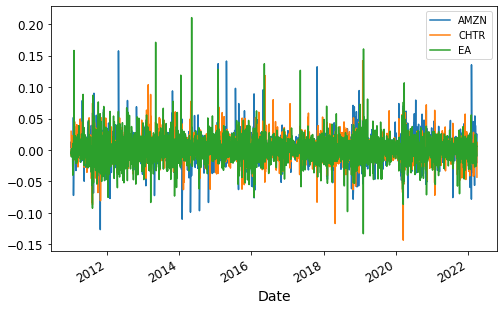

In [4]:
# calculate returns
stock_names = prices.columns
dates = prices.index[1:]
prices_array = prices.to_numpy()
returns_raw = np.empty((prices.shape[0]-1, prices.shape[1]))
for j in range(prices.shape[1]):
    for i in range(prices.shape[0]-1):
        returns_raw[i, j] = prices_array[i+1, j]/prices_array[i, j] - 1
        
# # scale the returns - not to be used if build_lstm uses BatchNormalization()
# std_scaler = StandardScaler()
# returns_array = std_scaler.fit_transform(returns_raw)

# a sample of returns look roughly stationary, so no differencing will be done
returns = pd.DataFrame(returns_raw, index=dates, columns=stock_names)
returns.iloc[:,[10,20, 30]].plot(figsize=(8, 5))
returns_array = np.array(returns)

# calculate daily medians
daily_medians = np.median(returns_array, axis=1)

# classify each daily return as above or below the daily median
classifications_array = np.empty((returns.shape[0], returns.shape[1]))
for j in range(returns.shape[1]):
    for i in range(returns.shape[0]):
        classifications_array[i, j] = returns_array[i, j] >= daily_medians[i]

classifications = pd.DataFrame(classifications_array, index=dates
                                , columns=stock_names)

t_load = time.time() - t0
print('Load and Transform Time: {:.2f}s'.format(t_load), '\n')

The number of training days per year and per month are estimated as 264 and 22.  Training sets are multiples of a year and test sets are one month, which is an attempt to capture seasonality in the data.  *ts_split()* is used to convert the time series into sequences, then some constants are calculated that help to determine which sequence to start with and which prices to use to calculate the return.

In [5]:
# set constants
n_returns = returns_array.shape[0]
n_stocks = returns_array.shape[1]
trd_days_per_year = 264
n_one_step_forecasts = 22
x_sequence_length = trd_days_per_year
n_sequences = returns.shape[0] - x_sequence_length

n_training_points = 3 * trd_days_per_year + x_sequence_length
n_training_sequences = n_training_points - x_sequence_length
n_test_points = n_one_step_forecasts + x_sequence_length
n_test_sequences = n_test_points - x_sequence_length
n_sequences_used = n_training_sequences + n_test_sequences

# this function is from the class notes
# it is used to form the time sequences
def ts_split(ts, feature_steps=x_sequence_length, target_steps=1):
    
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y.ravel()
    
# call ts_split() to generate sequences
X = np.empty((returns.shape[0] - x_sequence_length, x_sequence_length, n_stocks))
y = np.empty((returns.shape[0] - x_sequence_length, n_stocks))
for m in range(n_stocks):
    X[:,:,m], y[:,m] = ts_split(returns_array[:,m])

n_block_points = n_training_points + n_test_points
n_blocks = (n_sequences - n_sequences_used) // n_one_step_forecasts
offset_n_blocks = n_blocks - 1
n_time_points_used = n_training_points  + n_blocks * n_one_step_forecasts
start_index = X.shape[0] - ((n_blocks - offset_n_blocks - 1) * n_one_step_forecasts + n_sequences_used)
prices_start_at = n_returns - n_time_points_used + 1

print('Number of Returns:', n_returns)
print('Number of Stocks:', n_stocks)
print('Number of Trading Days per Year:', trd_days_per_year)
print('Number of One-Step Forecasts:', n_one_step_forecasts)
print('X Sequence Length:', x_sequence_length)
print('Number of Sequences:', n_sequences, '\n')
print('Number of Points per Block:', n_block_points)
print('Number of Blocks:', n_blocks)
print('Number of Blocks to Offset:', offset_n_blocks, '\n')
print('Number of Training Points:', n_training_points)
print('Number of Test Points:', n_test_points)
print('Number of Time Points Used (All Blocks):', n_time_points_used)
print('Prices Start At:', prices_start_at, '\n')
print('Number of Training Sequences:', n_training_sequences)
print('Number of Test Sequences:', n_test_sequences)
print('Number of Time Sequences Used:', n_sequences_used, '\n')
print('X.shape, y.shape:', X.shape, y.shape)
print('X Start Index:', start_index, '\n')

Number of Returns: 2830
Number of Stocks: 83
Number of Trading Days per Year: 264
Number of One-Step Forecasts: 22
X Sequence Length: 264
Number of Sequences: 2566 

Number of Points per Block: 1342
Number of Blocks: 79
Number of Blocks to Offset: 78 

Number of Training Points: 1056
Number of Test Points: 286
Number of Time Points Used (All Blocks): 2794
Prices Start At: 37 

Number of Training Sequences: 792
Number of Test Sequences: 22
Number of Time Sequences Used: 814 

X.shape, y.shape: (2566, 264, 83) (2566, 83)
X Start Index: 1752 



In [6]:
# select a random subset, use a list of saved models, or use all

# stocks_to_process = random.sample(list(stock_names), n_stocks // 2)
# stocks_to_process = ['AAPL']
stocks_to_process = list(stock_names)

# data frame for final results
results_summary = pd.DataFrame(data=dict((name, [0]) for name in ['Average CV Accuracy', 
                                                                  'Test Set Accuracy', 
                                                                  'Predicted Days Above Median',
                                                                  'Actual Days Above Median',
                                                                  'Return']),
                               index=stocks_to_process)

Several functions are defined here.  The first calculates the return for the prediction window.  The stock is assumed to be held for the entire period, so the return is calculated from the first and last price in the window.

*time_series_cv()* is from the class notes.  It splits the series into nested training and validation sets, averages the accuracy over all folds, and saves the best model.  Saved models can be loaded by setting train_models = False, which will bypass the calls to *time_series_cv()*.

The last function builds the RNN.  It consists of an input layer, batch normalization, LSTM layer, batch normalization, and a Dense layer.  The LSTM cells use sigmoid activation functions for the recurrent input and tanh for the output activation function.  The dense layer outputs the predicted probability that the next day's return will be above the day's median return, so the activation function is sigmoid.  With these activation functions in mind, the only weight initializations used will be Glorot Normal and Glorot Uniform.  The *build_lstm()* call is in a hyperparameter loop that trains many random selections of hyperparameters and keeps the best according to cross-validation accuracy.  The loss function for the model is binary crossentropy and the evaluation metric is accuracy.

In [7]:
# this funciton is to calculate the return on the test set
def get_return(stock, start, end):
    print('Buy price:', prices[stock][start])
    print('Sell price:', prices[stock][end])
    print('Return:', prices[stock][end]/prices[stock][start] - 1)
    return (prices[stock][end]/prices[stock][start] - 1)

# this function is from the class notes
# it is used for time series cross validation
def time_series_cv(X, y, model, stock, n_split=3):
    
    print('Cross-Validating', stock)
    tscv = TimeSeriesSplit(n_splits=n_split)
    accuracy_scores = []
    i = 0
    
    for train_index, valid_index in tscv.split(X):
        
        i += 1
        
        # Split
        X_train_split, X_valid_split = X[train_index], X[valid_index]
        X_train_split, X_valid_split = X_train_split[..., np.newaxis], X_valid_split[..., np.newaxis]
        y_train_split, y_valid_split = y[train_index], y[valid_index]
        # print('Set sizes:\n', X_train_split.shape, y_train_split.shape)
        
        model.fit(X_train_split, y_train_split, epochs=50, verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=5,
                                                           monitor='accuracy',
                                                           mode='max',
                                                           restore_best_weights=True)])
        y_hat = model.predict(X_valid_split)
        y_hat_class = np.empty(y_hat.shape[0])
        for j in range(y_hat.shape[0]):
            y_hat_class[j] = y_hat[j] >= 0.5
        validation_accuracy = accuracy_score(y_valid_split, y_hat_class)
        accuracy_scores = np.append(accuracy_scores, validation_accuracy)
    
    print('CV Accuracy Scores:\n', accuracy_scores)
    print('Average CV Accuracy Score:\n', np.mean(accuracy_scores))
                
    #update best_model
    if np.mean(accuracy_scores) > best_model['accuracy']:
        best_model['accuracy'] = np.mean(accuracy_scores)
        best_model['model'] = model
        best_model['param'] = param
        results_summary.at[stock, 'Average CV Accuracy'] = np.mean(accuracy_scores)
    
# this function will build the LSTM model
def build_lstm (n_neurons=3, 
                input_shape=(None, 1), 
                dropout=0.06,
                recurrent_dropout=0.14, 
                lstm_initializer=keras.initializers.GlorotUniform(),
                dense_initializer=keras.initializers.GlorotUniform(),
                optimizer=keras.optimizers.Adam()):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(n_neurons, 
                                activation='tanh', 
                                recurrent_activation='sigmoid', 
                                dropout=dropout,
                                recurrent_dropout=recurrent_dropout, 
                                kernel_initializer=lstm_initializer))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'
                                  ,kernel_initializer=dense_initializer))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

This is where the heavy lifting is done.  There are several nested loops.  Adjust the range in each to have greater control over the output.

The outer loop is intended to shift the prediction window forward in time.  The script is currently not configured to store results from multiple periods and the time to process a block is long, so the block is set to predict the final days of the download with offset_n_blocks.

The next loop processes the stocks set in stocks_to_process.  An if-else statement controls whether models will be trained or loaded for all stocks_to_process.

If new models are to be trained, a hyperparameter loop will train multiple models with random selections of hyperparameters and save the best model.  The parameter dictionary includes dropout, recurrent dropout, number of neurons in the LSTM layer, LSTM initializer, dense layer initializer, and optimizer.  The best model is determined according to average cross-validation accuracy generated by time_series_cv().  The best model is then refit to the entire training set, and predictions are made on the test set and evaluated.  The script is currently set to evaluate seven points from the hyperparameter space.

In [8]:
# loop through the blocks
for i in range(1):
# for i in range(n_blocks - offset_n_blocks):
    
    tb = time.time()
    
    print('Training Block Number', i + offset_n_blocks + 1)
    print('First Sequence Index:', start_index, '\n')
        
    # split X and y into training, test
    training_index = start_index + (i * n_one_step_forecasts)
    test_index = training_index + n_training_sequences
    end_block_index = test_index + n_one_step_forecasts
    
    X_train, y_train = X[training_index:test_index,:,:], classifications_array[training_index:test_index,:]
    X_test, y_test= X[test_index:end_block_index,:,:], classifications_array[test_index:end_block_index,:]
    print('Data Shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')
    
    # get the price indices that correspond to y_test
    # these prices are used to calculate the return
    # the stock is bought at the start of the prediction period and sold at the end
    prices_start_index = prices_start_at + (offset_n_blocks * n_one_step_forecasts) + n_training_points
    prices_end_index = prices_start_index + n_one_step_forecasts - 1
    print('Prices Start Index:', prices_start_index)
    print('Prices End Index:', prices_end_index)
    
    # for each stock
    # for stock in ['AAPL']:
    for stock in stocks_to_process:
        
        stock_index = stock_names.get_loc(stock)            
        model_save_name = 'models/' + f'{(i + offset_n_blocks + 1):04}' + '_' + stock + '.h5'
        
        if train_models:
            
            print('\nTraining', stock, ':\n')
            
            # hyperparameter pool
            param_dist = {
                            'dropout': reciprocal(0.05,0.3).rvs(1000).tolist(),
                            'recurrent_dropout': reciprocal(0.05,0.3).rvs(1000).tolist(),
                            'n_neurons': np.arange(1, 5).tolist(),
                            'learning_rate': reciprocal(3e-3, 0.3).rvs(1000).tolist(),
                            'lstm_initializer': [tf.keras.initializers.GlorotNormal(), tf.keras.initializers.GlorotUniform()],
                            'dense_initializer': [tf.keras.initializers.GlorotNormal(), tf.keras.initializers.GlorotUniform()]
                        }
            
            # best model variables
            best_model = {'accuracy': 0, 'model': None, 'param': None}
                
            t_cv = time.time()
            
            # determine number of random combinations from param_dist
            for n_rand_params in range(7):
                
                print('Random Parameter Set Number', n_rand_params + 1)
                    
                # randomly select hyperparameters
                param = {}
                
                for key in list(param_dist.keys()):
                    param[key] = random.choice(param_dist[key])
                
                # randomly select optimizer
                optimizer_dist = [keras.optimizers.Adam(learning_rate=param['learning_rate']),
                                  keras.optimizers.Nadam(learning_rate=param['learning_rate']),
                                  keras.optimizers.Adadelta(learning_rate=param['learning_rate'])]
                param['optimizer'] = random.choice(optimizer_dist)
                print('Building model with', param, '\n')
                    
                # fit the model
                model = build_lstm(dropout=param['dropout'],
                                    recurrent_dropout=param['recurrent_dropout'],
                                    n_neurons=param['n_neurons'],
                                    optimizer=param['optimizer'],
                                    lstm_initializer=param['lstm_initializer'],
                                    dense_initializer=param['dense_initializer'])
                t1 = time.time()
                time_series_cv(X_train[:,:,stock_index], 
                                y_train[:,stock_index], 
                                model, 
                                stock)                
                t_fit = time.time() - t1
                print(stock, 'Fit Time: {:.2f}s'.format(t_fit), '\n')
                
            t_cv_end = time.time() - t_cv
            print(stock, 'Hyperparameter Tuning Time: {:.2f}s'.format(t_cv_end), '\n')
        
            # model summary
            print(stock, 'Best Model Parameters:\n', best_model['param'], '\n')
            print(stock, 'Best Model Average CV Accuracy Score:\n', best_model['accuracy'], '\n')
            
            # refit with full training set
            best_model['model'].fit(np.reshape(X_train[:,:,stock_index], (X_train.shape[0], x_sequence_length, 1))
                                            , y_train[:,stock_index])
            
            # make predictions on the test set
            y_hat = best_model['model'].predict(np.reshape(X_test[:,:,stock_index], (X_test.shape[0], x_sequence_length, 1)))
            
            # evaluate the test set accuracy
            y_hat_class = np.empty(y_hat.shape[0])
            for j in range(y_hat.shape[0]):
                y_hat_class[j] = y_hat[j,0] >= 0.5
            test_accuracy = accuracy_score(y_test[:,stock_index], y_hat_class)
            print(stock, 'Test Set Accuracy:', test_accuracy)
            
            # fill the results_summary
            results_summary.at[stock, 'Test Set Accuracy'] = test_accuracy
            results_summary.at[stock, 'Return'] = get_return(stock,
                                                             prices_start_index,
                                                             prices_end_index)
            results_summary.at[stock, 'Predicted Days Above Median'] = np.sum(y_hat_class)
            results_summary.at[stock, 'Actual Days Above Median'] = np.sum(y_test[:,stock_index])
            
            best_model['model'].save(model_save_name)
            
        else:
            
            print('\nLoading model', stock, 'from', model_save_name, '\n')
            
            model = keras.models.load_model(model_save_name)
            
            # make predictions on the test set
            y_hat = model.predict(np.reshape(X_test[:,:,stock_index], (X_test.shape[0], x_sequence_length, 1)))
            
            # evaluate the test set accuracy
            y_hat_class = np.empty(y_hat.shape[0])
            for j in range(y_hat.shape[0]):
                y_hat_class[j] = y_hat[j,0] >= 0.5
            test_accuracy = accuracy_score(y_test[:,stock_index], y_hat_class)
            print(stock, 'Test Set Accuracy:', test_accuracy)
            
            # fill the results_summary
            results_summary.at[stock, 'Test Set Accuracy'] = test_accuracy
            results_summary.at[stock, 'Return'] = get_return(stock,
                                                             prices_start_index,
                                                             prices_end_index)
            results_summary.at[stock, 'Predicted Days Above Median'] = np.sum(y_hat_class)
            results_summary.at[stock, 'Actual Days Above Median'] = np.sum(y_test[:,stock_index])
    
    print('\nBlock Run Time: {:.2f}s'.format(time.time() - tb), '\n')
    
print('Total Run Time: {:.2f}s'.format(time.time() - t0))

Training Block Number 79
First Sequence Index: 1752 

Data Shapes: (792, 264, 83) (792, 83) (22, 264, 83) (22, 83) 

Prices Start Index: 2809
Prices End Index: 2830

Training AAPL :

Random Parameter Set Number 1
Building model with {'dropout': 0.06180513225956115, 'recurrent_dropout': 0.11577867019979043, 'n_neurons': 3, 'learning_rate': 0.005470733962036824, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D557D358B0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D557D35760>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D557D353A0>} 

Cross-Validating AAPL
CV Accuracy Scores:
 [0.51010101 0.54040404 0.54040404]
Average CV Accuracy Score:
 0.5303030303030304
AAPL Fit Time: 42.97s 

Random Parameter Set Number 2
Building model with {'dropout': 0.07153285738686853, 'recurrent_dropout': 0.0803906715278501, 'n_neurons': 2, 'learnin

Cross-Validating ADBE
CV Accuracy Scores:
 [0.5        0.52020202 0.53535354]
Average CV Accuracy Score:
 0.5185185185185186
ADBE Fit Time: 43.92s 

Random Parameter Set Number 6
Building model with {'dropout': 0.11529833694958869, 'recurrent_dropout': 0.054172495972140744, 'n_neurons': 2, 'learning_rate': 0.03706787175064799, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D56AAA3820>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D56AAA3910>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D559AF6460>} 

Cross-Validating ADBE
CV Accuracy Scores:
 [0.5        0.52020202 0.53535354]
Average CV Accuracy Score:
 0.5185185185185186
ADBE Fit Time: 45.72s 

Random Parameter Set Number 7
Building model with {'dropout': 0.20277868944224473, 'recurrent_dropout': 0.22464399707103372, 'n_neurons': 4, 'learning_rate': 0.019502472815675114, 'lstm_in

Cross-Validating ADP
CV Accuracy Scores:
 [0.48989899 0.53535354 0.45959596]
Average CV Accuracy Score:
 0.494949494949495
ADP Fit Time: 45.23s 

Random Parameter Set Number 2
Building model with {'dropout': 0.23584916666899694, 'recurrent_dropout': 0.22458129511062747, 'n_neurons': 3, 'learning_rate': 0.004561797104685548, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D559CB3400>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D559CB3910>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5870100A0>} 

Cross-Validating ADP
CV Accuracy Scores:
 [0.48484848 0.50505051 0.45454545]
Average CV Accuracy Score:
 0.48148148148148145
ADP Fit Time: 57.86s 

Random Parameter Set Number 3
Building model with {'dropout': 0.09925013198090706, 'recurrent_dropout': 0.10755667027142615, 'n_neurons': 2, 'learning_rate': 0.017375680682149754, 'lstm_

Cross-Validating ADSK
CV Accuracy Scores:
 [0.48484848 0.47474747 0.48484848]
Average CV Accuracy Score:
 0.48148148148148145
ADSK Fit Time: 33.75s 

Random Parameter Set Number 7
Building model with {'dropout': 0.2030878150805033, 'recurrent_dropout': 0.05443567738611241, 'n_neurons': 3, 'learning_rate': 0.047696522549089376, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D56A4C65E0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D56B0A9220>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D55EC1FA00>} 

Cross-Validating ADSK
CV Accuracy Scores:
 [0.51515152 0.52525253 0.51515152]
Average CV Accuracy Score:
 0.5185185185185185
ADSK Fit Time: 47.27s 

ADSK Hyperparameter Tuning Time: 317.50s 

ADSK Best Model Parameters:
 {'dropout': 0.2830732126861721, 'recurrent_dropout': 0.1387410656592023, 'n_neurons': 2, 'learning_rate': 0.019545239

Cross-Validating ALGN
CV Accuracy Scores:
 [0.48484848 0.48484848 0.51515152]
Average CV Accuracy Score:
 0.494949494949495
ALGN Fit Time: 44.10s 

Random Parameter Set Number 3
Building model with {'dropout': 0.2745034460407593, 'recurrent_dropout': 0.1590917490044024, 'n_neurons': 2, 'learning_rate': 0.01293609885480577, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D588A22610>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D588A225E0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D568AA3340>} 

Cross-Validating ALGN
CV Accuracy Scores:
 [0.48484848 0.51515152 0.51515152]
Average CV Accuracy Score:
 0.5050505050505051
ALGN Fit Time: 42.26s 

Random Parameter Set Number 4
Building model with {'dropout': 0.054072704541731104, 'recurrent_dropout': 0.10586855922420416, 'n_neurons': 2, 'learning_rate': 0.02989603192772656, 'lstm_initial

Cross-Validating AMAT
CV Accuracy Scores:
 [0.48989899 0.49494949 0.53535354]
Average CV Accuracy Score:
 0.5067340067340068
AMAT Fit Time: 54.74s 

AMAT Hyperparameter Tuning Time: 322.67s 

AMAT Best Model Parameters:
 {'dropout': 0.17566223769322778, 'recurrent_dropout': 0.09487359106782815, 'n_neurons': 1, 'learning_rate': 0.014647067161536808, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D593DEB550>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D593CC93A0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D55EAAD4C0>} 

AMAT Best Model Average CV Accuracy Score:
 0.5117845117845118 

25/25 [==============================] - 3s 101ms/step - loss: 0.9960 - accuracy: 0.5088
AMAT Test Set Accuracy: 0.5
Buy price: 132.85513305664062
Sell price: 131.478515625
Return: -0.01036179333058762

Training AMD :

Random Parameter Set Numbe

Cross-Validating AMGN
CV Accuracy Scores:
 [0.44949495 0.50505051 0.43434343]
Average CV Accuracy Score:
 0.46296296296296297
AMGN Fit Time: 47.92s 

Random Parameter Set Number 4
Building model with {'dropout': 0.05051797212551158, 'recurrent_dropout': 0.05714284965567347, 'n_neurons': 4, 'learning_rate': 0.04906028080310473, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D59550BFD0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5944A9040>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D597E08220>} 

Cross-Validating AMGN
CV Accuracy Scores:
 [0.55050505 0.50505051 0.56565657]
Average CV Accuracy Score:
 0.5404040404040403
AMGN Fit Time: 47.02s 

Random Parameter Set Number 5
Building model with {'dropout': 0.05145455712150624, 'recurrent_dropout': 0.1296979271216334, 'n_neurons': 4, 'learning_rate': 0.21708266693873743, 'lstm_initia

25/25 [==============================] - 3s 117ms/step - loss: 0.7601 - accuracy: 0.5101
AMZN Test Set Accuracy: 0.22727272727272727
Buy price: 3041.050048828125
Sell price: 3259.949951171875
Return: 0.07198168357278556

Training ANSS :

Random Parameter Set Number 1
Building model with {'dropout': 0.19465824508788454, 'recurrent_dropout': 0.21241622213632355, 'n_neurons': 4, 'learning_rate': 0.0032072070662494934, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5955CEEB0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D55EAADC70>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D55EAAD820>} 

Cross-Validating ANSS
CV Accuracy Scores:
 [0.50505051 0.46464646 0.42424242]
Average CV Accuracy Score:
 0.4646464646464647
ANSS Fit Time: 48.27s 

Random Parameter Set Number 2
Building model with {'dropout': 0.09622056245127474, 'recurren

Cross-Validating ASML
CV Accuracy Scores:
 [0.48484848 0.45454545 0.58585859]
Average CV Accuracy Score:
 0.5084175084175084
ASML Fit Time: 52.42s 

Random Parameter Set Number 5
Building model with {'dropout': 0.1318019983555282, 'recurrent_dropout': 0.0670153044385912, 'n_neurons': 3, 'learning_rate': 0.11264724889498351, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D59F720580>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D59F62C9D0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5A3B779D0>} 

Cross-Validating ASML
CV Accuracy Scores:
 [0.51515152 0.45454545 0.42929293]
Average CV Accuracy Score:
 0.4663299663299663
ASML Fit Time: 56.57s 

Random Parameter Set Number 6
Building model with {'dropout': 0.17167267750282122, 'recurrent_dropout': 0.0897332215357842, 'n_neurons': 1, 'learning_rate': 0.0033294738641171644, 'lstm_initi

25/25 [==============================] - 3s 120ms/step - loss: 0.6933 - accuracy: 0.5417
ATVI Test Set Accuracy: 0.45454545454545453
Buy price: 80.99854278564453
Sell price: 79.63663482666016
Return: -0.01681398099455378

Training AVGO :

Random Parameter Set Number 1
Building model with {'dropout': 0.161220530202717, 'recurrent_dropout': 0.1290168210588214, 'n_neurons': 3, 'learning_rate': 0.0520328926993262, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5A0A703A0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5A0A704F0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5A0A70760>} 

Cross-Validating AVGO
CV Accuracy Scores:
 [0.53535354 0.50505051 0.52525253]
Average CV Accuracy Score:
 0.521885521885522
AVGO Fit Time: 57.63s 

Random Parameter Set Number 2
Building model with {'dropout': 0.1117022330036379, 'recurrent_dropout': 

Cross-Validating AZN
CV Accuracy Scores:
 [0.47474747 0.47979798 0.51515152]
Average CV Accuracy Score:
 0.4898989898989899
AZN Fit Time: 45.68s 

Random Parameter Set Number 5
Building model with {'dropout': 0.08420617326977096, 'recurrent_dropout': 0.057145734073302895, 'n_neurons': 3, 'learning_rate': 0.017171475434479447, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5B14B5D90>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5B14B5E50>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D58B61F430>} 

Cross-Validating AZN
CV Accuracy Scores:
 [0.47474747 0.47979798 0.51515152]
Average CV Accuracy Score:
 0.4898989898989899
AZN Fit Time: 58.86s 

Random Parameter Set Number 6
Building model with {'dropout': 0.18911269140987574, 'recurrent_dropout': 0.19878323337980977, 'n_neurons': 3, 'learning_rate': 0.020110412603019132, 'lstm_initi

25/25 [==============================] - 3s 118ms/step - loss: 0.6931 - accuracy: 0.5240
BIDU Test Set Accuracy: 0.5909090909090909
Buy price: 160.57000732421875
Sell price: 132.3000030517578
Return: -0.17606030381115256

Training BIIB :

Random Parameter Set Number 1
Building model with {'dropout': 0.09940476167919335, 'recurrent_dropout': 0.23619634249783283, 'n_neurons': 3, 'learning_rate': 0.04306679981491639, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D598891730>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5AB1C0E80>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5AB1B80D0>} 

Cross-Validating BIIB
CV Accuracy Scores:
 [0.50505051 0.50505051 0.56060606]
Average CV Accuracy Score:
 0.5235690235690236
BIIB Fit Time: 55.92s 

Random Parameter Set Number 2
Building model with {'dropout': 0.07377929589848976, 'recurrent_dropout

CV Accuracy Scores:
 [0.50505051 0.47474747 0.47979798]
Average CV Accuracy Score:
 0.4865319865319866
BKNG Fit Time: 44.07s 

Random Parameter Set Number 5
Building model with {'dropout': 0.13182107563705156, 'recurrent_dropout': 0.08614776917703665, 'n_neurons': 3, 'learning_rate': 0.005426236489610059, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5AE5EC760>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5AE5F7370>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5AE4DC040>} 

Cross-Validating BKNG
CV Accuracy Scores:
 [0.49494949 0.47474747 0.47979798]
Average CV Accuracy Score:
 0.48316498316498313
BKNG Fit Time: 56.18s 

Random Parameter Set Number 6
Building model with {'dropout': 0.05071704058789922, 'recurrent_dropout': 0.07729465034620059, 'n_neurons': 3, 'learning_rate': 0.034696772131012764, 'lstm_initializer': <tensorflow

25/25 [==============================] - 3s 120ms/step - loss: 0.6936 - accuracy: 0.5038
CDNS Test Set Accuracy: 0.45454545454545453
Buy price: 157.4600067138672
Sell price: 164.4600067138672
Return: 0.044455732894259636

Training CHTR :

Random Parameter Set Number 1
Building model with {'dropout': 0.17075294726293402, 'recurrent_dropout': 0.1460647287176746, 'n_neurons': 1, 'learning_rate': 0.03822687225619135, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5BEEEE640>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5BEEE6670>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5BEE67430>} 

Cross-Validating CHTR
CV Accuracy Scores:
 [0.48989899 0.58585859 0.54545455]
Average CV Accuracy Score:
 0.5404040404040403
CHTR Fit Time: 35.67s 

Random Parameter Set Number 2
Building model with {'dropout': 0.08235101684141477, 'recurrent_d

Cross-Validating CMCSA
CV Accuracy Scores:
 [0.47474747 0.5        0.5       ]
Average CV Accuracy Score:
 0.49158249158249157
CMCSA Fit Time: 43.12s 

Random Parameter Set Number 5
Building model with {'dropout': 0.13610463938803913, 'recurrent_dropout': 0.05255379882189919, 'n_neurons': 1, 'learning_rate': 0.008841866280358232, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D59C86CB50>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5B2CAA430>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5B55CF5E0>} 

Cross-Validating CMCSA
CV Accuracy Scores:
 [0.5        0.48989899 0.48989899]
Average CV Accuracy Score:
 0.49326599326599324
CMCSA Fit Time: 35.24s 

Random Parameter Set Number 6
Building model with {'dropout': 0.281667586014166, 'recurrent_dropout': 0.14141599186639384, 'n_neurons': 3, 'learning_rate': 0.0044016032291072866

25/25 [==============================] - 3s 115ms/step - loss: 0.6946 - accuracy: 0.5227
COST Test Set Accuracy: 0.36363636363636365
Buy price: 527.1423950195312
Sell price: 574.9146118164062
Return: 0.09062488095859744

Training CPRT :

Random Parameter Set Number 1
Building model with {'dropout': 0.27962872551568946, 'recurrent_dropout': 0.10350312300758271, 'n_neurons': 2, 'learning_rate': 0.16354300391518517, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D597F1AF40>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5988A3E20>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5BE2D1490>} 

Cross-Validating CPRT
CV Accuracy Scores:
 [0.55555556 0.47979798 0.47979798]
Average CV Accuracy Score:
 0.5050505050505051
CPRT Fit Time: 41.85s 

Random Parameter Set Number 2
Building model with {'dropout': 0.07127283585448088, 'recurrent_dropo

Cross-Validating CSCO
CV Accuracy Scores:
 [0.53030303 0.53030303 0.55050505]
Average CV Accuracy Score:
 0.5370370370370371
CSCO Fit Time: 52.55s 

Random Parameter Set Number 5
Building model with {'dropout': 0.2795208441422202, 'recurrent_dropout': 0.05517390458407994, 'n_neurons': 1, 'learning_rate': 0.01296405025419532, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5D79823A0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5D7982490>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5B848C460>} 

Cross-Validating CSCO
CV Accuracy Scores:
 [0.5        0.52020202 0.55050505]
Average CV Accuracy Score:
 0.5235690235690237
CSCO Fit Time: 38.33s 

Random Parameter Set Number 6
Building model with {'dropout': 0.2271815119592017, 'recurrent_dropout': 0.08167803306689132, 'n_neurons': 2, 'learning_rate': 0.04058227542226606, 'lstm_

25/25 [==============================] - 3s 125ms/step - loss: 0.6903 - accuracy: 0.5114
CSX Test Set Accuracy: 0.5909090909090909
Buy price: 34.500404357910156
Sell price: 37.33141326904297
Return: 0.08205726755442289

Training CTAS :

Random Parameter Set Number 1
Building model with {'dropout': 0.1973458284977917, 'recurrent_dropout': 0.23625202265456566, 'n_neurons': 1, 'learning_rate': 0.005019910487357755, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5B8CAC4F0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5CA989520>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5CA989700>} 

Cross-Validating CTAS
CV Accuracy Scores:
 [0.56565657 0.51515152 0.51010101]
Average CV Accuracy Score:
 0.5303030303030303
CTAS Fit Time: 52.42s 

Random Parameter Set Number 2
Building model with {'dropout': 0.07321239218259765, 'recurrent_dropout': 

Cross-Validating CTSH
CV Accuracy Scores:
 [0.47979798 0.41414141 0.5       ]
Average CV Accuracy Score:
 0.4646464646464647
CTSH Fit Time: 45.06s 

Random Parameter Set Number 5
Building model with {'dropout': 0.11729031073574936, 'recurrent_dropout': 0.20071074542393275, 'n_neurons': 4, 'learning_rate': 0.003484854717268334, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5D4F8BB20>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5D50019D0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5DA8165E0>} 

Cross-Validating CTSH
CV Accuracy Scores:
 [0.47979798 0.41414141 0.5       ]
Average CV Accuracy Score:
 0.4646464646464647
CTSH Fit Time: 59.37s 

Random Parameter Set Number 6
Building model with {'dropout': 0.1499811709767914, 'recurrent_dropout': 0.0587616562219204, 'n_neurons': 4, 'learning_rate': 0.007922229015013865, 'lstm_initia

25/25 [==============================] - 3s 127ms/step - loss: 0.6971 - accuracy: 0.4634
DLTR Test Set Accuracy: 0.5454545454545454
Buy price: 139.9199981689453
Sell price: 160.14999389648438
Return: 0.14458258999626716

Training DXCM :

Random Parameter Set Number 1
Building model with {'dropout': 0.1833257269424827, 'recurrent_dropout': 0.05697378493431746, 'n_neurons': 3, 'learning_rate': 0.19860334465726204, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5DABA7A60>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5DABAE280>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5D92E3100>} 

Cross-Validating DXCM
CV Accuracy Scores:
 [0.53535354 0.46969697 0.52020202]
Average CV Accuracy Score:
 0.5084175084175085
DXCM Fit Time: 47.08s 

Random Parameter Set Number 2
Building model with {'dropout': 0.28045531639688603, 'recurrent_dropou

CV Accuracy Scores:
 [0.44949495 0.46464646 0.51010101]
Average CV Accuracy Score:
 0.47474747474747475
EA Fit Time: 45.97s 

Random Parameter Set Number 5
Building model with {'dropout': 0.11099532384383048, 'recurrent_dropout': 0.26163301054342186, 'n_neurons': 1, 'learning_rate': 0.004972714792482499, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5E9CD4FA0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5EA0A2FD0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5C4C842E0>} 

Cross-Validating EA
CV Accuracy Scores:
 [0.55050505 0.46464646 0.48989899]
Average CV Accuracy Score:
 0.5016835016835016
EA Fit Time: 40.32s 

Random Parameter Set Number 6
Building model with {'dropout': 0.06906238970787269, 'recurrent_dropout': 0.11590876562169301, 'n_neurons': 3, 'learning_rate': 0.08415632198520552, 'lstm_initializer': <tensorflow.python.

25/25 [==============================] - 3s 126ms/step - loss: 0.7656 - accuracy: 0.4773
EBAY Test Set Accuracy: 0.45454545454545453
Buy price: 54.61542510986328
Sell price: 57.0019645690918
Return: 0.043697168966968514

Training EXC :

Random Parameter Set Number 1
Building model with {'dropout': 0.1432859795388629, 'recurrent_dropout': 0.05633700616552209, 'n_neurons': 3, 'learning_rate': 0.25939565812478693, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5ECD09DC0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5ECD09C40>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5ECD26FD0>} 

Cross-Validating EXC
CV Accuracy Scores:
 [0.55050505 0.51515152 0.53030303]
Average CV Accuracy Score:
 0.531986531986532
EXC Fit Time: 62.62s 

Random Parameter Set Number 2
Building model with {'dropout': 0.1587046478320979, 'recurrent_dropout': 0.0

CV Accuracy Scores:
 [0.50505051 0.49494949 0.47979798]
Average CV Accuracy Score:
 0.49326599326599324
FAST Fit Time: 44.00s 

Random Parameter Set Number 5
Building model with {'dropout': 0.15773217730085387, 'recurrent_dropout': 0.12531952328813833, 'n_neurons': 1, 'learning_rate': 0.012217276077130097, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5F85DDA00>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5F85DDAF0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D5BBF0F280>} 

Cross-Validating FAST
CV Accuracy Scores:
 [0.52020202 0.48989899 0.47979798]
Average CV Accuracy Score:
 0.4966329966329967
FAST Fit Time: 57.56s 

Random Parameter Set Number 6
Building model with {'dropout': 0.05486837839206741, 'recurrent_dropout': 0.27358801999657567, 'n_neurons': 2, 'learning_rate': 0.003042795082652698, 'lstm_initializer': <tensorflow

25/25 [==============================] - 3s 110ms/step - loss: 0.6955 - accuracy: 0.4861
FISV Test Set Accuracy: 0.6818181818181818
Buy price: 98.73999786376953
Sell price: 101.4000015258789
Return: 0.026939474576243683

Training FTNT :

Random Parameter Set Number 1
Building model with {'dropout': 0.22026817367819163, 'recurrent_dropout': 0.2581971957144057, 'n_neurons': 3, 'learning_rate': 0.2978886400484464, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5D2E6DEB0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5E058EC10>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5E058EFA0>} 

Cross-Validating FTNT
CV Accuracy Scores:
 [0.54040404 0.49494949 0.53030303]
Average CV Accuracy Score:
 0.521885521885522
FTNT Fit Time: 69.28s 

Random Parameter Set Number 2
Building model with {'dropout': 0.06350260641993224, 'recurrent_dropout':

CV Accuracy Scores:
 [0.53535354 0.50505051 0.60606061]
Average CV Accuracy Score:
 0.5488215488215489
GILD Fit Time: 59.60s 

Random Parameter Set Number 5
Building model with {'dropout': 0.07161726969537915, 'recurrent_dropout': 0.1697646808250165, 'n_neurons': 4, 'learning_rate': 0.19322084515783752, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5F2EF5B50>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5F2EF5CD0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D5CAB645E0>} 

Cross-Validating GILD
CV Accuracy Scores:
 [0.53535354 0.49494949 0.60606061]
Average CV Accuracy Score:
 0.5454545454545454
GILD Fit Time: 55.61s 

Random Parameter Set Number 6
Building model with {'dropout': 0.07966868323397239, 'recurrent_dropout': 0.1451882977496079, 'n_neurons': 3, 'learning_rate': 0.01705161774253594, 'lstm_initializer': <tensorflow.p

CV Accuracy Scores:
 [0.47979798 0.50505051 0.56565657]
Average CV Accuracy Score:
 0.5168350168350169
HON Fit Time: 61.08s 

Random Parameter Set Number 5
Building model with {'dropout': 0.11977654775712032, 'recurrent_dropout': 0.21266233340395982, 'n_neurons': 3, 'learning_rate': 0.003505824737216562, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D602C08E50>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5CEADFD60>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D602B6A910>} 

Cross-Validating HON
CV Accuracy Scores:
 [0.50505051 0.48989899 0.48484848]
Average CV Accuracy Score:
 0.4932659932659933
HON Fit Time: 72.30s 

Random Parameter Set Number 6
Building model with {'dropout': 0.06076681867721037, 'recurrent_dropout': 0.14914992676397418, 'n_neurons': 3, 'learning_rate': 0.062398954722078834, 'lstm_initializer': <tensorflow.p

Cross-Validating INTC
CV Accuracy Scores:
 [0.52020202 0.47474747 0.54545455]
Average CV Accuracy Score:
 0.5134680134680135
INTC Fit Time: 71.02s 

Random Parameter Set Number 5
Building model with {'dropout': 0.0725951149079936, 'recurrent_dropout': 0.08927398820866723, 'n_neurons': 3, 'learning_rate': 0.012164152361493602, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5F1EAD910>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5D8EED970>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D61A6468E0>} 

Cross-Validating INTC
CV Accuracy Scores:
 [0.52020202 0.47474747 0.45454545]
Average CV Accuracy Score:
 0.4831649831649832
INTC Fit Time: 48.61s 

Random Parameter Set Number 6
Building model with {'dropout': 0.05712202579463493, 'recurrent_dropout': 0.05782919010944418, 'n_neurons': 1, 'learning_rate': 0.12186019013482409, 'lstm_initial

25/25 [==============================] - 3s 120ms/step - loss: 0.6901 - accuracy: 0.5328
INTU Test Set Accuracy: 0.36363636363636365
Buy price: 485.3323669433594
Sell price: 480.1794738769531
Return: -0.010617245865672142

Training ISRG :

Random Parameter Set Number 1
Building model with {'dropout': 0.09825541533879584, 'recurrent_dropout': 0.2572101388878007, 'n_neurons': 2, 'learning_rate': 0.023231950488643963, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D61A890280>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5DD631490>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5DD6318E0>} 

Cross-Validating ISRG
CV Accuracy Scores:
 [0.52020202 0.48989899 0.51010101]
Average CV Accuracy Score:
 0.5067340067340068
ISRG Fit Time: 57.75s 

Random Parameter Set Number 2
Building model with {'dropout': 0.05422000898231262, 'recurrent

Cross-Validating KDP
CV Accuracy Scores:
 [0.48484848 0.54040404 0.51010101]
Average CV Accuracy Score:
 0.5117845117845118
KDP Fit Time: 39.56s 

Random Parameter Set Number 5
Building model with {'dropout': 0.061956829662573244, 'recurrent_dropout': 0.1840391306258556, 'n_neurons': 4, 'learning_rate': 0.009577214064788437, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D6250E3FD0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5EA36A910>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D6075EBD60>} 

Cross-Validating KDP
CV Accuracy Scores:
 [0.47979798 0.54040404 0.51010101]
Average CV Accuracy Score:
 0.51010101010101
KDP Fit Time: 37.83s 

Random Parameter Set Number 6
Building model with {'dropout': 0.07326899442842365, 'recurrent_dropout': 0.16337879502176197, 'n_neurons': 2, 'learning_rate': 0.1429083467357374, 'lstm_initi

25/25 [==============================] - 3s 125ms/step - loss: 0.7441 - accuracy: 0.5278
KLAC Test Set Accuracy: 0.7272727272727273
Buy price: 344.91864013671875
Sell price: 364.84210205078125
Return: 0.057762786917416875

Training LRCX :

Random Parameter Set Number 1
Building model with {'dropout': 0.10721567809746183, 'recurrent_dropout': 0.05958706926133998, 'n_neurons': 3, 'learning_rate': 0.0038734261608194412, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D58F6F1A90>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D6144FDB50>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D6144FDD90>} 

Cross-Validating LRCX
CV Accuracy Scores:
 [0.53030303 0.42424242 0.54545455]
Average CV Accuracy Score:
 0.5
LRCX Fit Time: 56.19s 

Random Parameter Set Number 2
Building model with {'dropout': 0.07106230897569814, 'recurrent_dropout': 0.055466

CV Accuracy Scores:
 [0.48989899 0.47979798 0.53030303]
Average CV Accuracy Score:
 0.5
LULU Fit Time: 51.29s 

Random Parameter Set Number 5
Building model with {'dropout': 0.2615036748184662, 'recurrent_dropout': 0.10149585522867442, 'n_neurons': 2, 'learning_rate': 0.01915507791819935, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D6152E08B0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5A569C1F0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D60B92CF70>} 

Cross-Validating LULU
CV Accuracy Scores:
 [0.48484848 0.51515152 0.50505051]
Average CV Accuracy Score:
 0.5016835016835017
LULU Fit Time: 58.71s 

Random Parameter Set Number 6
Building model with {'dropout': 0.12786753995727138, 'recurrent_dropout': 0.11933404439319184, 'n_neurons': 1, 'learning_rate': 0.1984270299742825, 'lstm_initializer': <tensorflow.python.keras.initi

Cross-Validating MDLZ
CV Accuracy Scores:
 [0.47474747 0.50505051 0.48484848]
Average CV Accuracy Score:
 0.48821548821548827
MDLZ Fit Time: 46.85s 

Random Parameter Set Number 5
Building model with {'dropout': 0.07332158832555077, 'recurrent_dropout': 0.24562736556023823, 'n_neurons': 4, 'learning_rate': 0.005381445107654243, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D61C583D30>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D6184020A0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D60107C3A0>} 

Cross-Validating MDLZ
CV Accuracy Scores:
 [0.51515152 0.53535354 0.57070707]
Average CV Accuracy Score:
 0.5404040404040404
MDLZ Fit Time: 47.29s 

Random Parameter Set Number 6
Building model with {'dropout': 0.2378576231770897, 'recurrent_dropout': 0.05776746959843909, 'n_neurons': 3, 'learning_rate': 0.006688801457846668, '

25/25 [==============================] - 3s 127ms/step - loss: 0.6910 - accuracy: 0.5215
MELI Test Set Accuracy: 0.36363636363636365
Buy price: 1140.9000244140625
Sell price: 1189.47998046875
Return: 0.0425803795381956

Training MNST :

Random Parameter Set Number 1
Building model with {'dropout': 0.1056763144312877, 'recurrent_dropout': 0.08925879860390555, 'n_neurons': 4, 'learning_rate': 0.04340455488145709, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D61847F400>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D639D94520>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D639D94640>} 

Cross-Validating MNST
CV Accuracy Scores:
 [0.49494949 0.47979798 0.50505051]
Average CV Accuracy Score:
 0.49326599326599324
MNST Fit Time: 69.26s 

Random Parameter Set Number 2
Building model with {'dropout': 0.08196958039760777, 'recurrent_dropout

Cross-Validating MRVL
CV Accuracy Scores:
 [0.5        0.51010101 0.48989899]
Average CV Accuracy Score:
 0.49999999999999994
MRVL Fit Time: 49.81s 

Random Parameter Set Number 5
Building model with {'dropout': 0.2437983005206329, 'recurrent_dropout': 0.18665362734143276, 'n_neurons': 3, 'learning_rate': 0.11516163645512358, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5FA715340>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5FA715430>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D636C2F220>} 

Cross-Validating MRVL
CV Accuracy Scores:
 [0.5        0.51010101 0.48989899]
Average CV Accuracy Score:
 0.49999999999999994
MRVL Fit Time: 43.16s 

Random Parameter Set Number 6
Building model with {'dropout': 0.18275092485979572, 'recurrent_dropout': 0.10187015353524678, 'n_neurons': 4, 'learning_rate': 0.019705080244170992, 'l

25/25 [==============================] - 3s 129ms/step - loss: 0.8115 - accuracy: 0.5051
MSFT Test Set Accuracy: 0.36363636363636365
Buy price: 299.4924621582031
Sell price: 307.59356689453125
Return: 0.02704944451005531

Training MTCH :

Random Parameter Set Number 1
Building model with {'dropout': 0.19186349458935617, 'recurrent_dropout': 0.1266357021061865, 'n_neurons': 4, 'learning_rate': 0.003304573227538126, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D64BF8C1F0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D64BF8CA00>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D64BF8CCA0>} 

Cross-Validating MTCH
CV Accuracy Scores:
 [0.51010101 0.48484848 0.52020202]
Average CV Accuracy Score:
 0.5050505050505051
MTCH Fit Time: 67.01s 

Random Parameter Set Number 2
Building model with {'dropout': 0.11545635205740419, 'recurrent_drop

Cross-Validating MU
CV Accuracy Scores:
 [0.53535354 0.5        0.5       ]
Average CV Accuracy Score:
 0.5117845117845118
MU Fit Time: 48.93s 

Random Parameter Set Number 5
Building model with {'dropout': 0.14319573837861418, 'recurrent_dropout': 0.0846781047263867, 'n_neurons': 1, 'learning_rate': 0.023670815287318323, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D5F58E2D90>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5F58E2070>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D6164F8AF0>} 

Cross-Validating MU
CV Accuracy Scores:
 [0.46464646 0.5        0.5       ]
Average CV Accuracy Score:
 0.48821548821548816
MU Fit Time: 48.16s 

Random Parameter Set Number 6
Building model with {'dropout': 0.2623940553198078, 'recurrent_dropout': 0.05787981604092521, 'n_neurons': 3, 'learning_rate': 0.050273167214440924, 'lstm_initializer

Cross-Validating NVDA
CV Accuracy Scores:
 [0.52525253 0.52525253 0.49494949]
Average CV Accuracy Score:
 0.5151515151515152
NVDA Fit Time: 46.02s 

Random Parameter Set Number 5
Building model with {'dropout': 0.08318514696497172, 'recurrent_dropout': 0.20053158810995064, 'n_neurons': 1, 'learning_rate': 0.009398382789775537, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D61F71BBB0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D626901D00>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5F8E89A00>} 

Cross-Validating NVDA
CV Accuracy Scores:
 [0.49494949 0.54545455 0.5       ]
Average CV Accuracy Score:
 0.5134680134680135
NVDA Fit Time: 51.35s 

Random Parameter Set Number 6
Building model with {'dropout': 0.08342441501902544, 'recurrent_dropout': 0.22486984822228942, 'n_neurons': 2, 'learning_rate': 0.17881064806067465, 'ls

25/25 [==============================] - 3s 129ms/step - loss: 0.8879 - accuracy: 0.4861
NXPI Test Set Accuracy: 0.5
Buy price: 187.45867919921875
Sell price: 185.0800018310547
Return: -0.012689075684973572

Training ODFL :

Random Parameter Set Number 1
Building model with {'dropout': 0.1474991064759917, 'recurrent_dropout': 0.0684837373398528, 'n_neurons': 4, 'learning_rate': 0.17417879655439455, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D62E62F100>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D62221C700>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D62221CA90>} 

Cross-Validating ODFL
CV Accuracy Scores:
 [0.47474747 0.55050505 0.56060606]
Average CV Accuracy Score:
 0.5286195286195287
ODFL Fit Time: 78.76s 

Random Parameter Set Number 2
Building model with {'dropout': 0.11902579279661081, 'recurrent_dropout': 0.1229

Cross-Validating ORLY
CV Accuracy Scores:
 [0.55555556 0.44949495 0.46969697]
Average CV Accuracy Score:
 0.4915824915824916
ORLY Fit Time: 43.70s 

Random Parameter Set Number 5
Building model with {'dropout': 0.17429987191941176, 'recurrent_dropout': 0.14003861101258808, 'n_neurons': 3, 'learning_rate': 0.011004826514887354, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D615109820>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D615109B80>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D65D2664F0>} 

Cross-Validating ORLY
CV Accuracy Scores:
 [0.55555556 0.44949495 0.54545455]
Average CV Accuracy Score:
 0.5168350168350169
ORLY Fit Time: 52.39s 

Random Parameter Set Number 6
Building model with {'dropout': 0.23133801103440735, 'recurrent_dropout': 0.0725147752225462, 'n_neurons': 1, 'learning_rate': 0.02566598653249633, 'lstm_ini

25/25 [==============================] - 3s 130ms/step - loss: 0.6956 - accuracy: 0.4937
PAYX Test Set Accuracy: 0.6363636363636364
Buy price: 119.5883560180664
Sell price: 135.5725555419922
Return: 0.1336601660575636

Training PCAR :

Random Parameter Set Number 1
Building model with {'dropout': 0.10233331637380619, 'recurrent_dropout': 0.054690836719095776, 'n_neurons': 4, 'learning_rate': 0.0030909954877062053, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D644FC94F0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D65F0B6700>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D65F0B6B20>} 

Cross-Validating PCAR
CV Accuracy Scores:
 [0.47474747 0.52020202 0.55050505]
Average CV Accuracy Score:
 0.5151515151515151
PCAR Fit Time: 47.96s 

Random Parameter Set Number 2
Building model with {'dropout': 0.08154218368597882, 'recurrent_

Cross-Validating PEP
CV Accuracy Scores:
 [0.53535354 0.52020202 0.43939394]
Average CV Accuracy Score:
 0.4983164983164983
PEP Fit Time: 51.41s 

Random Parameter Set Number 5
Building model with {'dropout': 0.15210709412724954, 'recurrent_dropout': 0.19029467240983877, 'n_neurons': 2, 'learning_rate': 0.21033180231318846, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D656F47B20>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D656F47A60>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D656D93280>} 

Cross-Validating PEP
CV Accuracy Scores:
 [0.49494949 0.53030303 0.56565657]
Average CV Accuracy Score:
 0.5303030303030303
PEP Fit Time: 55.11s 

Random Parameter Set Number 6
Building model with {'dropout': 0.16303937111012595, 'recurrent_dropout': 0.06567659803297796, 'n_neurons': 2, 'learning_rate': 0.08077680494537469, 'lstm_initiali

25/25 [==============================] - 3s 131ms/step - loss: 0.7174 - accuracy: 0.4987
QCOM Test Set Accuracy: 0.6363636363636364
Buy price: 168.3636932373047
Sell price: 152.0197296142578
Return: -0.09707534509836657

Training REGN :

Random Parameter Set Number 1
Building model with {'dropout': 0.10195005389552479, 'recurrent_dropout': 0.13033199341394838, 'n_neurons': 2, 'learning_rate': 0.033297095439100866, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D664CE4760>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D664CE48B0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D664CE4AF0>} 

Cross-Validating REGN
CV Accuracy Scores:
 [0.46464646 0.48989899 0.46969697]
Average CV Accuracy Score:
 0.47474747474747475
REGN Fit Time: 92.58s 

Random Parameter Set Number 2
Building model with {'dropout': 0.29814114742531334, 'recurrent_dropo

Cross-Validating ROST
CV Accuracy Scores:
 [0.54040404 0.50505051 0.48484848]
Average CV Accuracy Score:
 0.51010101010101
ROST Fit Time: 36.68s 

Random Parameter Set Number 5
Building model with {'dropout': 0.0646443284469682, 'recurrent_dropout': 0.28248401908754633, 'n_neurons': 2, 'learning_rate': 0.005801081505062354, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D65D9FB2B0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D643905940>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D668656640>} 

Cross-Validating ROST
CV Accuracy Scores:
 [0.54040404 0.50505051 0.48484848]
Average CV Accuracy Score:
 0.51010101010101
ROST Fit Time: 43.27s 

Random Parameter Set Number 6
Building model with {'dropout': 0.12684895804756868, 'recurrent_dropout': 0.16621588677695753, 'n_neurons': 4, 'learning_rate': 0.005900010823476795, 'lstm_initializ

25/25 [==============================] - 3s 133ms/step - loss: 0.6933 - accuracy: 0.5013
SBUX Test Set Accuracy: 0.5909090909090909
Buy price: 92.12116241455078
Sell price: 90.33375549316406
Return: -0.01940278297122744

Training SGEN :

Random Parameter Set Number 1
Building model with {'dropout': 0.056241625487772645, 'recurrent_dropout': 0.08102458254305922, 'n_neurons': 2, 'learning_rate': 0.00411767424830564, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D66C7E85B0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D66C7E83A0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D66C7E8280>} 

Cross-Validating SGEN
CV Accuracy Scores:
 [0.5        0.53535354 0.48989899]
Average CV Accuracy Score:
 0.5084175084175084
SGEN Fit Time: 61.19s 

Random Parameter Set Number 2
Building model with {'dropout': 0.282427228615108, 'recurrent_d

Cross-Validating SIRI
CV Accuracy Scores:
 [0.50505051 0.5        0.45454545]
Average CV Accuracy Score:
 0.4865319865319866
SIRI Fit Time: 75.95s 

Random Parameter Set Number 5
Building model with {'dropout': 0.1897773387834369, 'recurrent_dropout': 0.25449853227970576, 'n_neurons': 4, 'learning_rate': 0.003937974003256682, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D660AD3C40>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D668021DC0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D65D690D90>} 

Cross-Validating SIRI
CV Accuracy Scores:
 [0.50505051 0.5        0.56565657]
Average CV Accuracy Score:
 0.5235690235690237
SIRI Fit Time: 75.64s 

Random Parameter Set Number 6
Building model with {'dropout': 0.1737311960810333, 'recurrent_dropout': 0.22503662873892907, 'n_neurons': 1, 'learning_rate': 0.1075739396758953, 'lstm_initia

25/25 [==============================] - 3s 113ms/step - loss: 0.9084 - accuracy: 0.5063
SNPS Test Set Accuracy: 0.4090909090909091
Buy price: 315.32000732421875
Sell price: 333.2699890136719
Return: 0.05692623770300931

Training SWKS :

Random Parameter Set Number 1
Building model with {'dropout': 0.23290246449483445, 'recurrent_dropout': 0.07351622245344389, 'n_neurons': 2, 'learning_rate': 0.0037828961507885587, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D672CACF70>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D672CB4F40>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D63DB843D0>} 

Cross-Validating SWKS
CV Accuracy Scores:
 [0.53535354 0.47474747 0.47979798]
Average CV Accuracy Score:
 0.4966329966329967
SWKS Fit Time: 48.62s 

Random Parameter Set Number 2
Building model with {'dropout': 0.20264462404845945, 'recurrent_dropou

Cross-Validating TMUS
CV Accuracy Scores:
 [0.52020202 0.49494949 0.51515152]
Average CV Accuracy Score:
 0.51010101010101
TMUS Fit Time: 38.62s 

Random Parameter Set Number 5
Building model with {'dropout': 0.1023978053043547, 'recurrent_dropout': 0.26725334490573055, 'n_neurons': 2, 'learning_rate': 0.0075763210611502815, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D66F51B520>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D614C2B160>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D66F464BE0>} 

Cross-Validating TMUS
CV Accuracy Scores:
 [0.51515152 0.5        0.51515152]
Average CV Accuracy Score:
 0.51010101010101
TMUS Fit Time: 64.26s 

Random Parameter Set Number 6
Building model with {'dropout': 0.1012283771915819, 'recurrent_dropout': 0.15124382402669173, 'n_neurons': 2, 'learning_rate': 0.004654875072358352, 'lstm_initia

25/25 [==============================] - 4s 141ms/step - loss: 0.7161 - accuracy: 0.5088
TSLA Test Set Accuracy: 0.5
Buy price: 879.8900146484375
Sell price: 1077.5999755859375
Return: 0.22469849372764572

Training TXN :

Random Parameter Set Number 1
Building model with {'dropout': 0.0689167542161267, 'recurrent_dropout': 0.07033594085957882, 'n_neurons': 2, 'learning_rate': 0.014577438245440836, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotUniform object at 0x000001D65D706430>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D65D706520>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D65D706820>} 

Cross-Validating TXN
CV Accuracy Scores:
 [0.48989899 0.50505051 0.45454545]
Average CV Accuracy Score:
 0.4831649831649832
TXN Fit Time: 54.66s 

Random Parameter Set Number 2
Building model with {'dropout': 0.14558225161754587, 'recurrent_dropout': 0.06764429977368

CV Accuracy Scores:
 [0.54545455 0.55050505 0.51515152]
Average CV Accuracy Score:
 0.5370370370370371
VRSK Fit Time: 56.40s 

Random Parameter Set Number 5
Building model with {'dropout': 0.1783765278370821, 'recurrent_dropout': 0.1730934613539896, 'n_neurons': 1, 'learning_rate': 0.074451017283544, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5BD09DA60>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D67B81E4C0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x000001D67BC7BE80>} 

Cross-Validating VRSK
CV Accuracy Scores:
 [0.54545455 0.55050505 0.51515152]
Average CV Accuracy Score:
 0.5370370370370371
VRSK Fit Time: 40.27s 

Random Parameter Set Number 6
Building model with {'dropout': 0.1564239138941643, 'recurrent_dropout': 0.0844521636292114, 'n_neurons': 3, 'learning_rate': 0.019790813124297257, 'lstm_initializer': <tensorflow.python

25/25 [==============================] - 3s 123ms/step - loss: 0.6999 - accuracy: 0.4937
VRSN Test Set Accuracy: 0.5454545454545454
Buy price: 217.85000610351562
Sell price: 222.4600067138672
Return: 0.021161351761271208

Training VRTX :

Random Parameter Set Number 1
Building model with {'dropout': 0.05393021372288488, 'recurrent_dropout': 0.05094396218008479, 'n_neurons': 4, 'learning_rate': 0.00767269545443455, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5EA127A00>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D600EA8EB0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D62DD2AEB0>} 

Cross-Validating VRTX
CV Accuracy Scores:
 [0.49494949 0.47979798 0.55050505]
Average CV Accuracy Score:
 0.5084175084175083
VRTX Fit Time: 62.19s 

Random Parameter Set Number 2
Building model with {'dropout': 0.25892844645271346, 'recurrent_

Cross-Validating WBA
CV Accuracy Scores:
 [0.46464646 0.46969697 0.47979798]
Average CV Accuracy Score:
 0.4713804713804714
WBA Fit Time: 75.47s 

Random Parameter Set Number 5
Building model with {'dropout': 0.2955202859625753, 'recurrent_dropout': 0.13196208650373617, 'n_neurons': 4, 'learning_rate': 0.02919287192858451, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D68D221BB0>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D68D22C5E0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D5E560FB50>} 

Cross-Validating WBA
CV Accuracy Scores:
 [0.45959596 0.47474747 0.47474747]
Average CV Accuracy Score:
 0.4696969696969697
WBA Fit Time: 61.27s 

Random Parameter Set Number 6
Building model with {'dropout': 0.06359584694722582, 'recurrent_dropout': 0.14852921524991594, 'n_neurons': 4, 'learning_rate': 0.048314986146650966, 'lstm_ini

25/25 [==============================] - 3s 134ms/step - loss: 0.6941 - accuracy: 0.4975
XEL Test Set Accuracy: 0.36363636363636365
Buy price: 67.09148406982422
Sell price: 72.16999816894531
Return: 0.07569536088716888

Block Run Time: 31212.61s 

Total Run Time: 31214.61s


The mean and median are positive and the distribution of returns looks to be slightly positively skewed.

In [48]:
print('Average of Returns for Processed Stocks:', np.mean(results_summary['Return']))
print('Median of Returns for Processed Stocks:', np.median(results_summary['Return']))

Average of Returns for Processed Stocks: 0.030962048304441197
Median of Returns for Processed Stocks: 0.02407539034154782


array([[<AxesSubplot:title={'center':'Return'}>]], dtype=object)

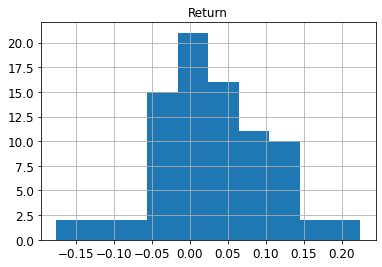

In [26]:
results_summary.hist('Return')

Fjellström notes in her paper that 'the accuracies are shown to be just near 50%, which is consistent with
findings in literature (see, for example, [3, 11, 22])'.  The same was seen here, with an average test set accuracy of 0.498.  Flip a coin anyone?

In [44]:
print('Average Test Set Accuracy:', results_summary['Test Set Accuracy'].mean(),
     '\nStandard Deviation of Test Set Accuracy:', results_summary['Test Set Accuracy'].std())

Average Test Set Accuracy: 0.4978094194961665 
Standard Deviation of Test Set Accuracy: 0.11222036052139948


The table below shows all stocks where the model predicted all days would be above the median.  Of those, there was one stock with 18 days actually above the median and two with 15, everything else was even worse.  There may be some sort of bias, but it also seems conceivable that some returns could be above the median for long periods of consecutive days and this information may be picked up by the model.  Maybe the early stopping patience level could be raised from five and the learning rate may benefit from scheduling, but I'm not really emboldened by the results so far.

In [47]:
results_summary.loc[results_summary['Predicted Days Above Median'] == n_one_step_forecasts].sort_values(
    ['Predicted Days Above Median', 'Average CV Accuracy'],axis=0, ascending=False)

,Average CV Accuracy,Test Set Accuracy,Predicted Days Above Median,Actual Days Above Median,Return
IDXX,0.570707,0.500000,22,11,0.013130
SNPS,0.562290,0.409091,22,9,0.056926
CDNS,0.547138,0.454545,22,10,0.044456
ANSS,0.542088,0.454545,22,10,-0.017324
CHTR,0.540404,0.590909,22,13,-0.044607
ATVI,0.538721,0.454545,22,10,-0.016814
ASML,0.538721,0.545455,22,12,0.019165
VRSK,0.537037,0.454545,22,10,0.183052
INTU,0.535354,0.363636,22,8,-0.010617
ILMN,0.533670,0.272727,22,6,0.058179


array([[<AxesSubplot:title={'center':'Actual Days Above Median'}>]],
      dtype=object)

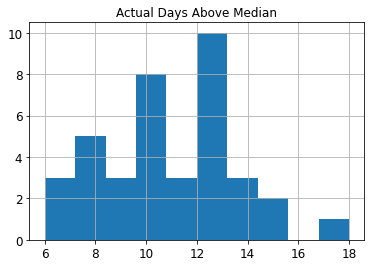

In [45]:
results_summary.loc[results_summary['Predicted Days Above Median'] == n_one_step_forecasts].hist(
    column='Actual Days Above Median')

Of the rest, the winner to me looks like KLAC (KLA Corp).  72.7% on the test set, 15 predicted, 13 actual and a return of 0.058.  From the training output, we can get the hyperparameters and see if using them as a starting point for a finer search of the space improves results.

KLAC Hyperparameter Tuning Time: 398.38s 

KLAC Best Model Parameters:
 {'dropout': 0.10886638639468756, 'recurrent_dropout': 0.08486149418330462, 'n_neurons': 2, 'learning_rate': 0.013039308814972726, 'lstm_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D608D36C70>, 'dense_initializer': <tensorflow.python.keras.initializers.initializers_v2.GlorotNormal object at 0x000001D5A559F0A0>, 'optimizer': <tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x000001D62A99BA60>} 

KLAC Best Model Average CV Accuracy Score:
 0.5521885521885522 

25/25 [==============================] - 3s 125ms/step - loss: 0.7441 - accuracy: 0.5278
KLAC Test Set Accuracy: 0.7272727272727273
Buy price: 344.91864013671875
Sell price: 364.84210205078125
Return: 0.057762786917416875

<AxesSubplot:title={'center':'KLAC Prices'}, xlabel='Date'>

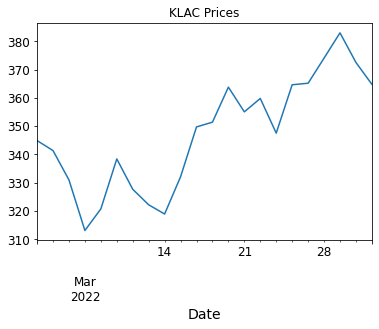

In [51]:
prices['KLAC'].iloc[prices_start_index:prices_end_index + 1].plot(title='KLAC Prices')

Another disappointment in the model is that it fails to detect several good investments.  It predicts zero days above the median for winners such as DLTR, SGEN, EXC and ADP.

In [46]:
results_summary.loc[results_summary['Predicted Days Above Median'] != n_one_step_forecasts].sort_values(
    ['Predicted Days Above Median', 'Average CV Accuracy'],axis=0, ascending=False)

,Average CV Accuracy,Test Set Accuracy,Predicted Days Above Median,Actual Days Above Median,Return
ODFL,0.537037,0.681818,21,14,-0.060666
TXN,0.516835,0.500000,21,10,0.078660
AMAT,0.511785,0.500000,21,12,-0.010362
AZN,0.510101,0.590909,20,13,0.070000
MU,0.511785,0.454545,19,13,-0.165166
MSFT,0.543771,0.363636,16,8,0.027049
MNST,0.518519,0.636364,16,12,-0.045970
KLAC,0.552189,0.727273,15,13,0.057763
MDLZ,0.540404,0.545455,15,13,-0.024260
TSLA,0.501684,0.500000,14,7,0.224698


In all, the results disappoint, but they don't sound far from what is to be expected.  Furthermore, the prediction window is March 2022 and the markets have been rought lately.  Still, the pipeline is built and endless tweaking may improve results.  The full loop took 8.5 hours to train and used huge amounts of resources, so the following implementations will have to wait:
* Run the script in the cloud.  This would allow a more thorough search of the hyperparameter space and training of models on more stocks
* Learning rate scheduler
* Determine if there is an association between certain values of the randomly chosen hyperparameters and the cross validation accuracy
* Add number of LSTM layers to the hyperparameter space and build_lstm()
* Increase the patience on the early stopper
* Increase the number of points sampled from the hyperparameter space
* Investigate different lengths of sequences and prediction windows
* Run the training over multiple blocks
* Try a different length for the prediction window
* Compare to ARIMA models

### Resources
* Long Short-Term Memory Neural Network for Financial Time Series by Carmina Fjellström. (https://arxiv.org/abs/2201.08218)
* Slickcharts (https://www.slickcharts.com/nasdaq100)
* Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow (Géron)
* Course Notes, CFRM 521, University of Washington, Spring 2022 (Lu)